In [1]:
import torch
import os
import json
from utils import *
from cnn import SimpleCNN
from resnet import MyResNET
from vit import MyViT
from gradcam import *

/opt/anaconda3/envs/ml_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vmazeeva (vmazeeva-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


In [2]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
data = '../chest_xray/train'

img_size = (512,512)
img_norm = True

simpleCNN_path = '../models/SimpleCNN_lr3e-05_img512_b16_finetune.pth'
resNET_path = '../models/ResNET_lr3e-05_img512_b32.pth'
viT_path = '../models/ViT_lr3e-05_b32.pth'

In [4]:
dataset_cnn = DatasetWithPaths(data, transform=get_common_transform(img_size))
dataset_vit = DatasetWithPaths(data, transform=vit_transform)

dataloader_cnn = get_dataloader(dataset_cnn, 1, shuffle=False)
dataloader_vit = get_dataloader(dataset_vit, 1, shuffle=False)

In [5]:
simpleCNN = SimpleCNN()
simpleCNN.load_state_dict(torch.load(simpleCNN_path, map_location=DEVICE, weights_only=True))

resNET = MyResNET()
resNET.load_state_dict(torch.load(resNET_path, map_location=DEVICE, weights_only=True))

viT = MyViT()
viT.load_state_dict(torch.load(viT_path, map_location=DEVICE, weights_only=True))

simpleCNN = simpleCNN.to(DEVICE)
resNET = resNET.to(DEVICE)
viT = viT.to(DEVICE)

/opt/anaconda3/envs/ml_ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml_ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def has_none_values(nested_dict):
    """
    Check if a nested dictionary contains any None values.

    Args:
        nested_dict (dict): The nested dictionary to check.

    Returns:
        bool: True if any None values are found, False otherwise.
    """
    for key, value in nested_dict.items():
        if isinstance(value, dict):  # If value is a nested dictionary
            if has_none_values(value):  # Recursively check the sub-dictionary
                return True
        elif value is None:  # Check if the value is None
            return True
    return False

In [7]:
def eval_conditions(pred, label, img_path, model, examples):
    if pred.item() == label.item():
        if label.item() == 0:  # Normal correctly classified
            examples["TN"][model] = img_path
        elif label.item() == 1:  # Pneumonia correctly classified
            examples["TP"][model] = img_path
    elif label.item() == 0 and pred.item() == 1:  # Normal misclassified as Pneumonia
        examples["FP"][model] = img_path
    elif label.item() == 1 and pred.item() == 0:  # Pneumonia misclassified as Normal
        examples["FN"][model] = img_path

In [8]:
examples = {
    "TN": {'SimpleCNN': None, 'ResNET': None, 'ViT': None},
    "FP": {'SimpleCNN': None, 'ResNET': None, 'ViT': None},
    "FN": {'SimpleCNN': None, 'ResNET': None, 'ViT': None},
    "TP": {'SimpleCNN': None, 'ResNET': None, 'ViT': None},
    "all_TN": None,
    "all_TP": None,
}

if os.path.exists('../models/models_cm.json'):
    with open('../models/models_cm.json', 'r') as f:
        examples = json.load(f)
    
    
else:

    # Loop through dataloaders
    for (img_cnn, label_cnn, (path_cnn,)), (img_vit, label_vit, (path_vit,)) in zip(dataloader_cnn, dataloader_vit):
        # Ensure the labels match between dataloaders
        assert label_cnn.item() == label_vit.item(), "Labels do not match between dataloaders."
        assert path_cnn == path_vit

        img_path = path_cnn

        label = label_cnn.to(DEVICE)
        img_cnn = img_cnn.to(DEVICE)  # CNN input
        img_vit = img_vit.to(DEVICE)  # ViT input

        # Get predictions from all three models
        pred_simpleCNN = simpleCNN(img_cnn).argmax(dim=1)
        pred_resNET = resNET(img_cnn).argmax(dim=1)
        pred_viT = viT(img_vit).logits.argmax(dim=1)

        # Evaluate conditions for individual cases 
        eval_conditions(pred_simpleCNN, label, img_path, 'SimpleCNN', examples)
        eval_conditions(pred_resNET, label, img_path, 'ResNET', examples)
        eval_conditions(pred_viT, label, img_path, 'ViT', examples)

        # Check if all models correctly classify Normal and Pneumonia
        if pred_simpleCNN.item() == pred_resNET.item() == pred_viT.item() == label.item():
            if label.item() == 0 and examples["all_TN"] is None:
                examples["all_TN"] = img_path
            elif label.item() == 1 and examples["all_TP"] is None:
                examples["all_TP"] = img_path

        # Stop if all examples are found
        if not has_none_values(examples): break

    # Print the examples found
    for key, value in examples.items():
        if value:
            print(f"{key}: Found an example.")
        else:
            print(f"{key}: Example not found.")


In [9]:
with open('../models/models_cm.json', 'w') as f:
    json.dump(examples, f)
examples

{'TN': {'SimpleCNN': '../chest_xray/train/NORMAL/NORMAL2-IM-1442-0001.jpeg',
  'ResNET': None,
  'ViT': '../chest_xray/train/NORMAL/NORMAL2-IM-1442-0001.jpeg'},
 'FP': {'SimpleCNN': '../chest_xray/train/NORMAL/NORMAL2-IM-1438-0001.jpeg',
  'ResNET': '../chest_xray/train/NORMAL/NORMAL2-IM-1442-0001.jpeg',
  'ViT': '../chest_xray/train/NORMAL/NORMAL2-IM-1422-0001.jpeg'},
 'FN': {'SimpleCNN': '../chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg',
  'ResNET': None,
  'ViT': '../chest_xray/train/PNEUMONIA/person798_virus_1430.jpeg'},
 'TP': {'SimpleCNN': '../chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg',
  'ResNET': '../chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg',
  'ViT': '../chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'},
 'all_TN': None,
 'all_TP': '../chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'}

Saved Grad-CAM overlay to gradcam/vit_TP.png


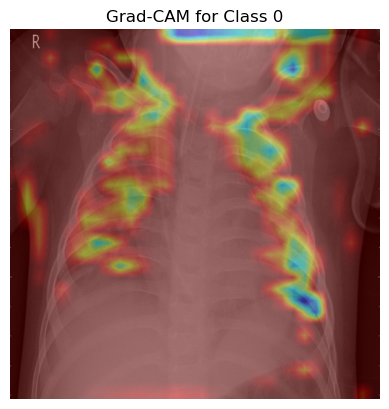

In [10]:
for error_type in examples.keys():
    if 'all' in error_type: continue

image = Image.open(examples['TP']['ViT']).convert("L").resize(img_size)  # Ensure grayscale

grad_cam = GradCAM(simpleCNN, simpleCNN.conv_stack[-2], DEVICE)
grad_cam.visualize_gradcam(image, 0, 'gradcam/vit_TP.png')

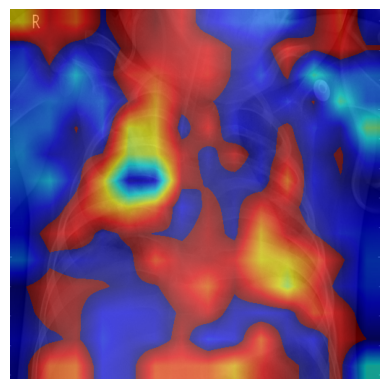

In [11]:
from tiba import TiBA

image = Image.open(examples['TP']['ViT']).convert("RGB").resize(img_size)

tiba = TiBA(viT.model, DEVICE)

importance = tiba.compute_importance(image, 1)

# Visualize the importance heatmap
tiba.visualize_importance(image, importance)

In [12]:
output = simpleCNN(torch.randn(1, 1, img_size[0], img_size[1]))
print(output.shape)  # Should be (1, num_classes)

torch.Size([1, 2])


In [17]:
from lime import LIMEExplainer

transform = get_common_transform(img_size)

# Load an example image
image = Image.open(examples['TP']['ResNET']).convert("L").resize((256,256))

# Initialize the LIME explainer
explainer = LIMEExplainer(simpleCNN, device=DEVICE)

# Explain the prediction for target class 1
explanation_weights, segments = explainer.explain(image, transform, num_segments=50, target_class=1)

# Visualize the explanation
explainer.visualize(explanation_weights, segments, image, save_path='save.png')

RuntimeError: MPS backend out of memory (MPS allocated: 16.74 GB, other allocations: 2.92 MB, max allowed: 18.13 GB). Tried to allocate 7.81 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [14]:
"""from SHAP import KernelSHAPExplainer

explainer = KernelSHAPExplainer(simpleCNN, DEVICE)

transform = get_common_transform(img_size)

image = Image.open(examples['TP']['SimpleCNN']).convert("L").resize(img_size)  # Ensure grayscale

# Explain the prediction
shap_values, segments = explainer.explain(image, transform, num_segments=256, target_class=1)

# Visualize the explanation
explainer.visualize(shap_values, segments, image)"""

'from SHAP import KernelSHAPExplainer\n\nexplainer = KernelSHAPExplainer(simpleCNN, DEVICE)\n\ntransform = get_common_transform(img_size)\n\nimage = Image.open(examples[\'TP\'][\'SimpleCNN\']).convert("L").resize(img_size)  # Ensure grayscale\n\n# Explain the prediction\nshap_values, segments = explainer.explain(image, transform, num_segments=256, target_class=1)\n\n# Visualize the explanation\nexplainer.visualize(shap_values, segments, image)'